## 0) Packages

In [ ]:
!pip install -q torch transformers
!pip install -q accelerate bitsandbytes
!pip install -q sentence-transformers
!pip install -q faiss-gpu
# !pip install -q faiss
# !pip install -q faiss-cpu

!pip install --upgrade --quiet  cohere
!pip install pypdf datasets
!pip install -q langchain
!pip install ragas==0.1.4
# !pip install torch torchvision -U

In [48]:
import getpass
import os
from getpass import getpass
from utils.utils_print import pretty_print_docs
from utils.utils_dset import get_knet_all_urls, get_knet_urls_recursive
import pandas as pd

# for Google Colab users:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

# import torch
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print('Running on', device)

In [ ]:
# # If required:
# ACCESS_TOKEN_GITHUB = getpass("Github Personal Token: ")
# ACCES_TOKEN_HugF = getpass("HuggingFace Token: ")

In [ ]:
os.environ["COHERE_API_KEY"] = getpass("Cohere API Key:")

## 1) Dataset

1. If you have a .csv file you can use this cell to load your documents:

In [ ]:
# # If you do not have a dataset with
# # four column: question, ground_truth, answer, context,
# # but still want to upload CSV with full of
# # text and text source, select column and metadata source:

from langchain.document_loaders.csv_loader import CSVLoader

df = pd.read_csv('./knet_v1_indFalse (1).csv')


loader = CSVLoader(file_path='./knet_v1_indFalse (1).csv',
                   source_column="p_content",
                   metadata_columns = ["url"]
                   )
docs = loader.load()

print(len(docs))
print(docs[2].metadata["url"])

df.head()

2. If you have multiple .pdf files, you can use this cell:

In [ ]:
# PDF Text Loader

from langchain.document_loaders import PyPDFLoader, DirectoryLoader
# loader = TextLoader('single_text_file.pdf')
loader = DirectoryLoader('./pdf_sources/',
                         glob="./*.pdf",
                         loader_cls=PyPDFLoader
                         )

docs = loader.load()
len(docs)

3. If you have a .csv file with question-answer-ground truth-context
columns, you can use this cell to load your documents:


In [ ]:
### Load Dataset

from datasets import load_dataset

# create Q&A in format of CSV with DF
DSET_SOURCE = "XXXXX"

qa_docs = load_dataset(DSET_SOURCE)
df_docs = pd.DataFrame.from_dict(qa_docs)
print("DataFrame length:",len(df_docs))

df_docs.to_csv('df_qa.csv', index=False)
df_docs.head()


In [ ]:
### Get context and load as docs
df_contexts = df_docs.drop(['answer',"ground_truth", "question"],
                                      axis=1)
df_contexts.to_csv('df_contexts.csv', index=False)
df_contexts.head()

In [ ]:
from langchain.document_loaders.csv_loader import CSVLoader
loader_contexts = CSVLoader(file_path='./df_answers.csv',
                   )
docs = loader_contexts.load()
print(len(docs))
docs[:5]

In [ ]:
IND = 26
print(docs[IND].metadata["source"])
print(docs[IND].page_content)

In [ ]:
for u in docs:
  print(u.metadata["url"])

### 1.1) Text Splitter

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from utils.utils_dset import MARKDOWN_SEPARATORS        # use it with arg 'seperators'

splitter = RecursiveCharacterTextSplitter(chunk_size = 512,
                                          chunk_overlap = 64,
                                          add_start_index=True,         # add chunk's start index in metadata
                                        #   strip_whitespace=True,        # start and end of every doc
                                          )

chunked_docs = splitter.split_documents(docs)
print(len(chunked_docs))

## 2) Embeddings

In [41]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

device = "cuda"

model_kwargs = {'device': device}
encode_kwargs = {'normalize_embeddings': True}  # set True for cosine similarity


# model_name = "thenlper/gte-small"
# model_name = "BAAI/bge-large-en"
model_name = "BAAI/bge-base-en"

embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    multi_process=True,
    model_kwargs = model_kwargs,
    encode_kwargs = encode_kwargs
)



## 3) DB and Retriever

In [43]:
from langchain_community.vectorstores import FAISS

db_faiss = FAISS.from_documents(
            chunked_docs,
            embeddings,
            distance_strategy = DistanceStrategy.COSINE
            )

retriever = db_faiss.as_retriever(
            # search_type ="mmr",               # "similarity"
            search_kwargs={"k": 8},
            )

In [ ]:
query1 = "What Unat did in TÜBİTAK project?"

search_docs = db_faiss.similarity_search(query1)
print(search_docs[0].page_content)

In [ ]:
docs_rel = retriever.get_relevant_documents(query1)
docs_rel

## 4) Reader - LLM

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "HuggingFaceH4/zephyr-7b-alpha"

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name,
                                             quantization_config=bnb_config
                                             )

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          # padding=True,
                                          # truncation=True
                                          )

tokenizer.pad_token = tokenizer.eos_token

In [46]:
from langchain.llms import HuggingFacePipeline
from transformers import pipeline

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.01,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=512,
    # batch_size=2,
)

text_generation_pipeline.model.config.pad_token_id = text_generation_pipeline.model.config.eos_token_id

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)



In [ ]:
docs_src = retriever.get_relevant_documents(query1)
pretty_print_docs(docs_src)

## 6) Chain

In [56]:
from langchain.chains import RetrievalQA
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,       # retriever or compression_retriever
    # chain_type="refine",
    # return_source_documents=True,
    )

In [ ]:
# RAG-based Answer
qa_chain({"query": query1})

# # # only results:
# print(chain({"query": query})["result"])

In [ ]:
print(qa_chain({"query": query1})["result"])

In [ ]:
# # def get_src_urls(src_docs):
# #   for d in src_docs:
# #     # print("1")
# #     # print(d.metadata["url"])
# #     print(d.metadata["source"])


from utils.utils_print import get_src_urls

get_src_urls(qa_chain({"query": query1})["source_documents"])

Prompt Template

In [66]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough


PROMPT_TEMP =  """Use the following context to answer the question:
{context}
Question: {question}
Helpful Answer:"""


prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=PROMPT_TEMP,
)

llm_chain = prompt | llm | StrOutputParser()

# llm_chain = (
#     {"context": compression_retriever,  "question": RunnablePassthrough()}
#     | prompt
#     | llm
#     | StrOutputParser()
# )

# llm_chain.invoke(query)

In [ ]:
# LLM-based Answer
llm_chain.invoke({"context": "", "question": query2})

In [ ]:
# RAG Chain Answer
from langchain_core.runnables import RunnablePassthrough

rag_chain = {"context": retriever, "question": RunnablePassthrough()} | llm_chain
rag_chain.invoke(query2)


## 7) Evaluation

In [ ]:
from datasets import Dataset

# 1) Questions
questions_dset = []

# 2) Labels
ground_truths_dset = []

# 3) LLM Answers
# 4) Retrivere Model's Contexts
answers_rag = []
contexts_rag = []

for query in questions_dset:
    answers_rag.append(rag_chain.invoke(query))
    contexts_rag.append([d.page_content for d in comp_retriever.get_relevant_documents(query)])


data_test_dict = {
    "question": questions_dset,
    "answer": answers_rag,
    "contexts": contexts_rag,
    "ground_truths": ground_truths_dset
}


test_dset = Dataset.from_dict(data_test_dict)

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
    faithfulness,
)

# select metrics to evaluate
METRICS_RAGAS = [
            # context_relevancy,
            context_precision,
            context_recall,
            # faithfulness,
            answer_relevancy,
          ]


result_testset = evaluate(
    test_dset,
    llm = llm,
    embeddings = embeddings,
    metrics=METRICS_RAGAS,
)

result_testset

In [ ]:
df_testset = result_testset.to_pandas()
df_testset.head()

## Additional

In [ ]:
!nvidia-smi
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
!pip install matplotlib tqdm

In [6]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

  0%|          | 0/34 [00:00<?, ?it/s]

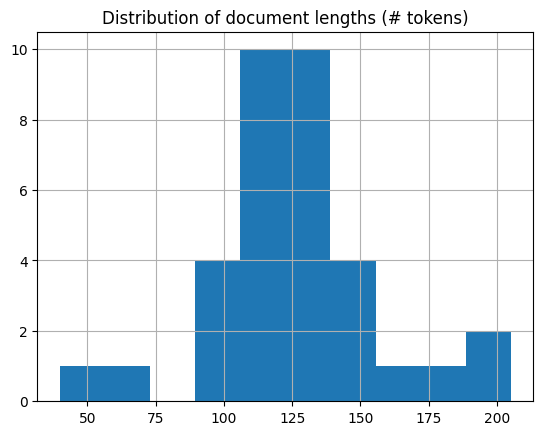

In [62]:
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(chunked_docs)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths (# tokens)")
plt.show()